### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


In [4]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("General demographics data shape:", azdias.shape)
azdias.head()

General demographics data shape: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [10]:
print("Feature summary shape:", feat_info.shape)
feat_info.head()

Feature summary shape: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
print("Missing values before preprocessing:", azdias.isnull().sum().sum())

Missing values before preprocessing: 4896838


In [13]:
# Check unique values in column
feat_info["missing_or_unknown"].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [14]:
# Loop over each row in feat_info (each feature of AZDIAS) to extract the missing_or_unknown values and replace them in AZDIAS df
for i in range(len(feat_info)):
    missing_or_unknown_values = feat_info.iloc[i]["missing_or_unknown"]
    missing_or_unknown_values = missing_or_unknown_values.strip("[").strip("]").split(",")
    missing_or_unknown_values_array = [int(v) if (v != '' and v != 'X' and v != 'XX') else v for v in missing_or_unknown_values]

    if len(missing_or_unknown_values_array) > 0:
        azdias = azdias.replace({feat_info.iloc[i]["attribute"]: missing_or_unknown_values_array}, np.nan)

print("Missing values before preprocessing:", azdias.isnull().sum().sum())

Missing values before preprocessing: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_percentage_cols = azdias.isnull().sum() / len(azdias) * 100

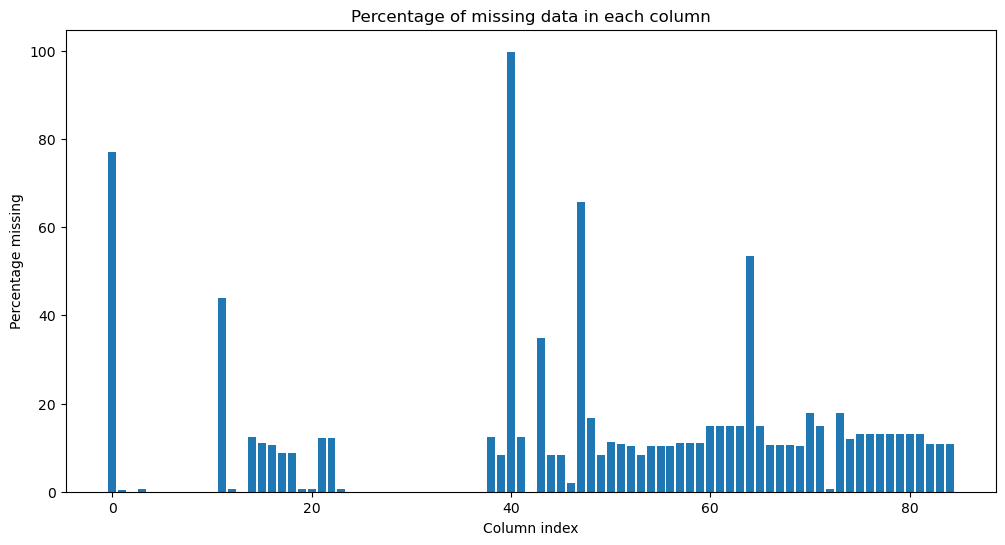

In [16]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12, 6))
plt.bar(range(len(missing_percentage_cols)), missing_percentage_cols)
plt.title('Percentage of missing data in each column')
plt.xlabel('Column index')
plt.ylabel('Percentage missing')
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Remove columns with >30% missing values
outlier_cols = missing_percentage_cols[missing_percentage_cols > 30]

print("Columns to drop: ", outlier_cols.index.tolist())

Columns to drop:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
# Drop columns
azdias = azdias.drop(outlier_cols.index.tolist(), axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

_(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)_

The histogram shows that most columns have less than 20% missing values, while a few have significantly higher percentages.

I set a 30% threshold for removal, as columns exceeding this value are unreliable for analysis. This threshold led to dropping six columns, while the remaining ones (with under 20% missing values) will be handled in the next preprocessing steps.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
missing_values_rows = azdias.isnull().sum(axis=1)

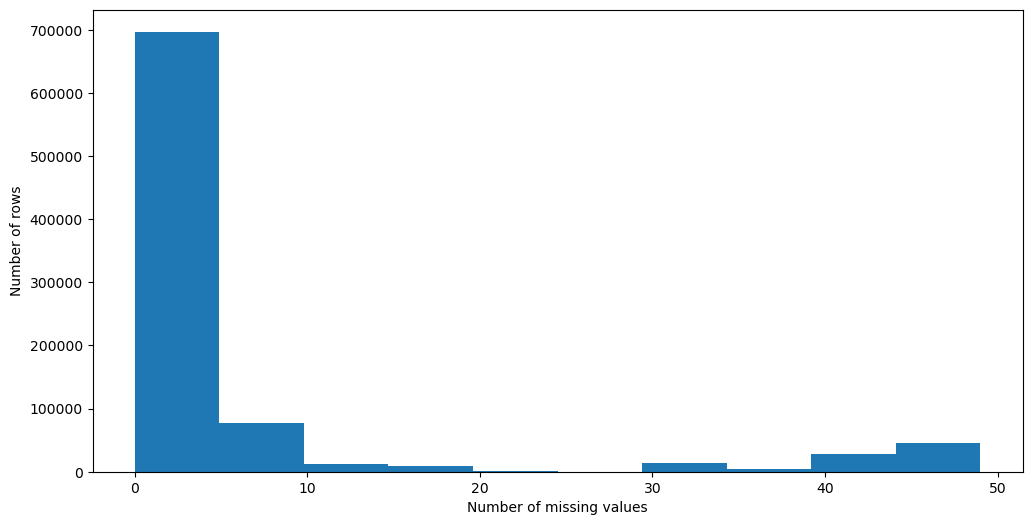

In [20]:
plt.figure(figsize=(12, 6))
plt.hist(missing_values_rows)
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')
plt.show()

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 30  # 30 missing values per row
missing_less_30 = azdias[missing_values_rows <= threshold]
missing_more_30 = azdias[missing_values_rows > threshold]

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing_cols = missing_percentage_cols[missing_percentage_cols == 0].index.tolist()
columns_to_compare = zero_missing_cols[:6]

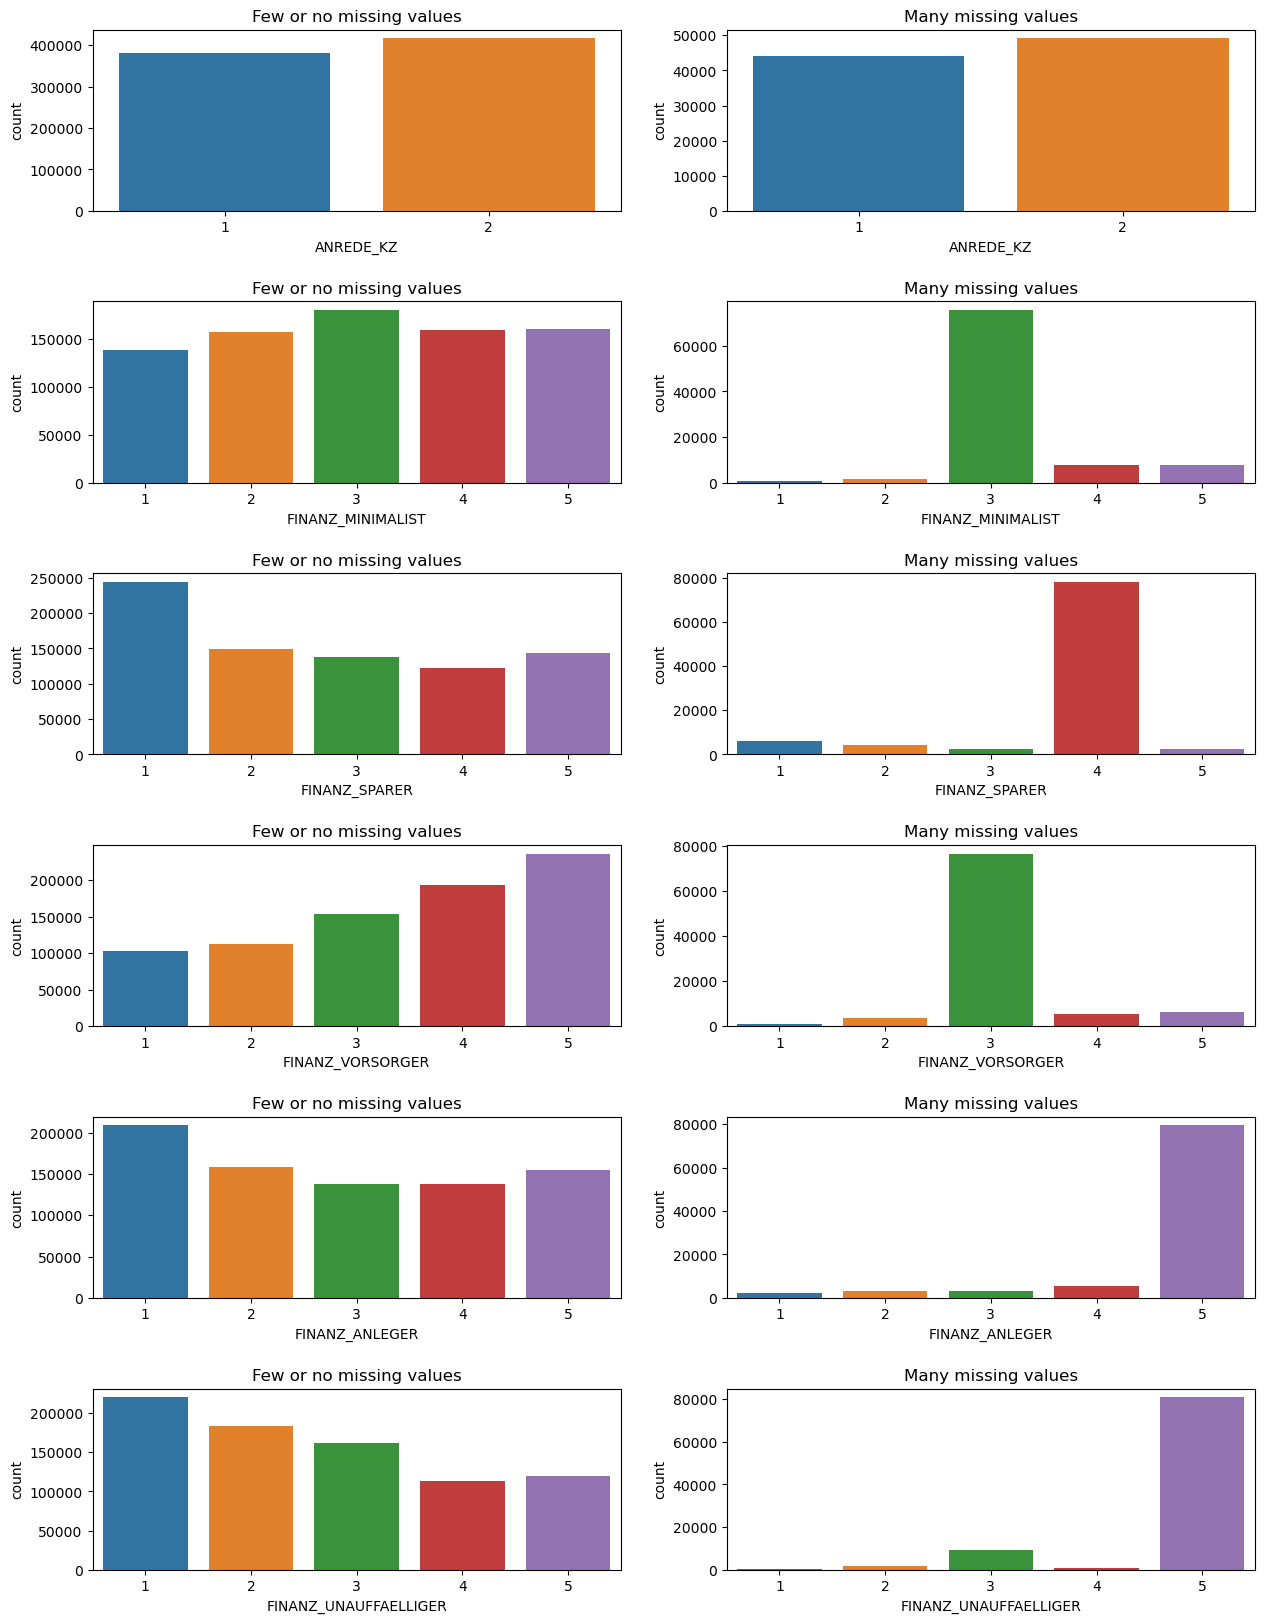

In [23]:
figure, axs = plt.subplots(nrows=len(columns_to_compare), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 0.5)

for i, col in enumerate(columns_to_compare):
    sns.countplot(x=col, data=missing_less_30, ax=axs[i, 0])
    axs[i, 0].set_title("Few or no missing values")
    sns.countplot(x=col, data=missing_more_30, ax=axs[i, 1])
    axs[i, 1].set_title("Many missing values")

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Only `ANREDE_KZ` shows a consistent distribution regardless of the amount of missing data, suggesting that it's completeness doesn't affect its distribution.

For the other columns, however, missing data isn't random - it's systematically related to specific customer types.

Columns with high missing values represent a particular subset of the population. Relying on heavy imputation could introduce bias by imposing patterns from the available data that may not hold for the missing data, leading to misleading relationships.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [25]:
# How many features are there of each data type?

feat_info = feat_info[feat_info["attribute"].isin(missing_less_30.columns)]
feat_info["type"].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info["type"] == "categorical"]
categorical_features

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

binary_cat = []
multi_cat = []

for col in categorical_features.attribute:
    if missing_less_30[col].nunique() == 2:
        binary_cat.append(col)
    else:
        multi_cat.append(col)

In [28]:
# Binary categorical features
for cat in binary_cat:
    print(f"Category: {cat} -- Values: {missing_less_30[cat].unique()}")

Category: ANREDE_KZ -- Values: [2 1]
Category: GREEN_AVANTGARDE -- Values: [0 1]
Category: SOHO_KZ -- Values: [1. 0.]
Category: VERS_TYP -- Values: [ 2.  1. nan]
Category: OST_WEST_KZ -- Values: ['W' 'O']


In [29]:
# Multi-level categorical features
for cat in multi_cat:
    print(f"Category: {cat} -- Values: {missing_less_30[cat].unique()}")

Category: CJT_GESAMTTYP -- Values: [ 5.  3.  2.  4.  1.  6. nan]
Category: FINANZTYP -- Values: [1 6 5 2 4 3]
Category: GFK_URLAUBERTYP -- Values: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
Category: LP_FAMILIE_FEIN -- Values: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
Category: LP_FAMILIE_GROB -- Values: [ 3.  1. nan  5.  2.  4.]
Category: LP_STATUS_FEIN -- Values: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
Category: LP_STATUS_GROB -- Values: [ 1.  2.  4.  5.  3. nan]
Category: NATIONALITAET_KZ -- Values: [ 1.  3.  2. nan]
Category: SHOPPER_TYP -- Values: [ 3.  2.  1.  0. nan]
Category: ZABEOTYP -- Values: [5 3 4 1 6 2]
Category: GEBAEUDETYP -- Values: [8. 1. 3. 2. 6. 4. 5.]
Category: CAMEO_DEUG_2015 -- Values: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
Category: CAMEO_DEU_2015 -- Values: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6

In [30]:
# Convert non-numeric binary categoricals to numeric
missing_less_30["OST_WEST_KZ"].replace({"W": 0, "O": 1}, inplace=True)

/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/781959157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["OST_WEST_KZ"].replace({"W": 0, "O": 1}, inplace=True)


In [31]:
# New binary categorical features
for cat in binary_cat:
    print(f"Category: {cat} -- Values: {missing_less_30[cat].unique()}")

Category: ANREDE_KZ -- Values: [2 1]
Category: GREEN_AVANTGARDE -- Values: [0 1]
Category: SOHO_KZ -- Values: [1. 0.]
Category: VERS_TYP -- Values: [ 2.  1. nan]
Category: OST_WEST_KZ -- Values: [0 1]


In [32]:
# Drop multi-level categoricals for simplicity
for cat in multi_cat:
    missing_less_30.drop(cat, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

After analyzing the categorical features in the dataset, we found both binary (two-level) and multi-level categorical features.

For binary categorical features we retained all of them since they already provide clear distinctions between two groups. Most were already encoded, except for `OST_WEST_KZ`, which we re-encoded from its original values (`W`/`0`) to (`0`/`1`).

Regarding multi-level categorical features, we considered one-hot encoding but decided to drop them entirely. One-hot encoding would've substantially increased the dimensionality of the already large dataset. To keep things simple, we decided to remove these features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print("PRAEGENDE_JUGENDJAHRE value counts:\n----")
print(missing_less_30["PRAEGENDE_JUGENDJAHRE"].value_counts().sort_index())

PRAEGENDE_JUGENDJAHRE value counts:
----
1.0      20678
2.0       7479
3.0      53845
4.0      20451
5.0      84692
6.0      25652
7.0       4010
8.0     141630
9.0      33570
10.0     85808
11.0     35752
12.0     24446
13.0      5764
14.0    182985
15.0     42547
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [34]:
# Let's map the decades as follows:
# '40s':1, '50s':2, '60s':3, '70s':4, '80s':5, '90s':6
decade_mapping = {
    1:1, 2:1,               # 40s
    3:2, 4:2,               # 50s
    5:3, 6:3, 7:3,          # 60s
    8:4, 9:4,               # 70s
    10:5, 11:5, 12:5, 13:5, # 80s
    14:6, 15:6              # 90s
}

# Let's map the movement as follows:
# 'Avantgarde':0, 'Mainstream':1
movement_mapping = {
    2:0, 4:0, 6:0, 7:0, 9:0, 11:0, 13:0, 15:0,  # Avantgarde
    1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1        # Mainstream
}

missing_less_30['DECADE'] = missing_less_30['PRAEGENDE_JUGENDJAHRE']
missing_less_30['MOVEMENT'] = missing_less_30['PRAEGENDE_JUGENDJAHRE']

missing_less_30['DECADE'].replace(decade_mapping, inplace = True)
missing_less_30['MOVEMENT'].replace(movement_mapping, inplace = True)

/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/3243778756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30['DECADE'] = missing_less_30['PRAEGENDE_JUGENDJAHRE']
/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/3243778756.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30['MOVEMENT'] = missing_less_30['PRAEGENDE_JUGENDJAHRE']
/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/3243778756.py:22: SettingWithCopyWarning: 
A valu

In [35]:
# Drop the original column
missing_less_30.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/3837146814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)


In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print("CAMEO_INTL_2015 value counts:\n----")
print(missing_less_30["CAMEO_INTL_2015"].value_counts().sort_index())

CAMEO_INTL_2015 value counts:
----
12     13249
13     26335
14     62884
15     16974
22     33154
23     26750
24     91158
25     39627
31     19024
32     10354
33      9935
34     18524
35     10356
41     92336
43     56672
44     14820
45     26132
51    133694
52     20542
54     45391
55     23955
Name: CAMEO_INTL_2015, dtype: int64


In [37]:
# Let's extract the 1st digit (wealth) and 2nd digit (life stage)

# Convert "CAMEO_INTL_2015" to string type for string operations
missing_less_30["CAMEO_INTL_2015"] = missing_less_30["CAMEO_INTL_2015"].astype(str)

def wealth_transform(x):
    if pd.isnull(x):
        return np.nan
    elif len(x) >=2 and x[0].isdigit():
        return int(x[0])
    else:
        return np.nan

def life_stage_transform(x):
    if pd.isnull(x):
        return np.nan
    elif len(x) >=2 and x[1].isdigit():
        return int(x[1])
    else:
        return np.nan

# Extract wealth (1st digit)
missing_less_30["WEALTH"] = missing_less_30["CAMEO_INTL_2015"].apply(wealth_transform)
missing_less_30["WEALTH"] = missing_less_30["CAMEO_INTL_2015"].apply(life_stage_transform)

/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/1774004346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["CAMEO_INTL_2015"] = missing_less_30["CAMEO_INTL_2015"].astype(str)
/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/1774004346.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["WEALTH"] = missing_less_30["CAMEO_INTL_2015"].apply(wealth_transform)
/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/1774004346.py:24: S

In [38]:
# Drop the original column
missing_less_30.drop(columns=["CAMEO_INTL_2015"], inplace=True)

/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/ipykernel_57965/1605004265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop(columns=["CAMEO_INTL_2015"], inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

We decided to extract meaningful information from `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` before dropping them.

From `PRAEGENDE_JUGENDJAHRE` we extracted the **decade** and **movement** as new separate features, using mappings to transform the original mixed-value representation into numerical values.

From `CAMEO_INTL_2015` we extracted **wealth** and **life stage** as new separate features, replacing the original mixed-value format with numerical values based on the 1st and 2nd digits.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [41]:
# Final check for any remaining categorical or mixed features
categorical_features = feat_info[feat_info["type"] == "categorical"]["attribute"]
mixed_features = feat_info[feat_info["type"] == "mixed"]["attribute"]

remaining_cat = [col for col in categorical_features if col in missing_less_30.columns]
remaining_mixed = [col for col in mixed_features if col in missing_less_30.columns]

print("Remaining categorical features:", remaining_cat)
print("Remaining mixed features:", remaining_mixed)

Remaining categorical features: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Remaining mixed features: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']


In [42]:
# Drop remaining categorical and mixed features
for feature in remaining_cat:
    missing_less_30 = missing_less_30.drop(feature, axis=1)

for feature in remaining_mixed:
    missing_less_30 = missing_less_30.drop(feature, axis=1)

In [43]:
azdias_subset = missing_less_30
azdias_subset.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH
1,1.0,1,5,2,5,4,5,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,1.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,4.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,2.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,3.0
5,1.0,3,1,5,2,2,5,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:
        df - Demographics DataFrame
        feat_info - Feature information DataFrame
        
    OUTPUT:
        Trimmed and cleaned demographics DataFrame
    """

    # 1. Convert missing value codes into NaNs
    df_clean = df.copy()
    print("Missing values before preprocessing:", df_clean.isnull().sum().sum())

    # Loop over each row in feat_info to extract missing_or_unknown values and replace them
    for i in range(len(feat_info)):
        missing_or_unknown_values = feat_info.iloc[i]["missing_or_unknown"]
        missing_or_unknown_values = missing_or_unknown_values.strip("[").strip("]").split(",")
        missing_or_unknown_values_array = [int(v) if (v != "" and v != "X" and v != "XX") else v
                                          for v in missing_or_unknown_values]
        if len(missing_or_unknown_values_array) > 0:
            df_clean = df_clean.replace({feat_info.iloc[i]["attribute"]: missing_or_unknown_values_array}, np.nan)

    print("Missing values after preprocessing:", df_clean.isnull().sum().sum())

    # 2. Remove columns with too many missing values (>30%)
    missing_percentage_cols = df_clean.isnull().sum() / len(df_clean) * 100
    outlier_cols = missing_percentage_cols[missing_percentage_cols > 30]
    print("Columns to drop:", outlier_cols.index.tolist())
    df_clean = df_clean.drop(outlier_cols.index.tolist(), axis=1)

    # 3. Remove rows with too many missing values (>30)
    missing_values_rows = df_clean.isnull().sum(axis=1)
    threshold = 30  # 30 missing values per row
    df_clean = df_clean[missing_values_rows <= threshold]

    # 4. Filter feat_info to only include columns that remain in df_clean
    feat_info_filtered = feat_info[feat_info["attribute"].isin(df_clean.columns)]

    # 5. Handle categorical features
    categorical_features = feat_info_filtered[feat_info_filtered["type"] == "categorical"]

    # Identify binary and multi-level categoricals
    binary_cat = []
    multi_cat = []
    for col in categorical_features.attribute:
        if df_clean[col].nunique() == 2:
            binary_cat.append(col)
        else:
            multi_cat.append(col)

    # Re-encode non-numeric binary categoricals
    if "OST_WEST_KZ" in binary_cat:
        df_clean["OST_WEST_KZ"].replace({"W": 0, "O": 1}, inplace=True)

    # Drop multi-level categoricals for simplicity
    df_clean = df_clean.drop(columns=multi_cat)

    # 6. Engineer mixed-type features
    # Handle "PRAEGENDE_JUGENDJAHRE"
    if "PRAEGENDE_JUGENDJAHRE" in df_clean.columns:
        # Decade mapping
        decade_mapping = {
            1:1, 2:1,                # 40s
            3:2, 4:2,                # 50s
            5:3, 6:3, 7:3,           # 60s
            8:4, 9:4,                # 70s
            10:5, 11:5, 12:5, 13:5,  # 80s
            14:6, 15:6               # 90s
        }
        # Movement mapping
        movement_mapping = {
            2:0, 4:0, 6:0, 7:0, 9:0, 11:0, 13:0, 15:0,  # Avantgarde
            1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1        # Mainstream
        }
        df_clean["DECADE"] = df_clean["PRAEGENDE_JUGENDJAHRE"]
        df_clean["MOVEMENT"] = df_clean["PRAEGENDE_JUGENDJAHRE"]
        df_clean["DECADE"].replace(decade_mapping, inplace=True)
        df_clean["MOVEMENT"].replace(movement_mapping, inplace=True)

        # Drop the original column
        df_clean.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

    # Handle "CAMEO_INTL_2015"
    if "CAMEO_INTL_2015" in df_clean.columns:
        # Convert to string type
        df_clean["CAMEO_INTL_2015"] = df_clean["CAMEO_INTL_2015"].astype(str)

        # Define transformation functions
        def wealth_transform(x):
            if pd.isnull(x):
                return np.nan
            elif len(x) >= 2 and x[0].isdigit():
                return int(x[0])
            else:
                return np.nan

        def life_stage_transform(x):
            if pd.isnull(x):
                return np.nan
            elif len(x) >= 2 and x[1].isdigit():
                return int(x[1])
            else:
                return np.nan

        # Extract wealth and life stage
        df_clean["WEALTH"] = df_clean["CAMEO_INTL_2015"].apply(wealth_transform)
        df_clean["LIFE_STAGE"] = df_clean["CAMEO_INTL_2015"].apply(life_stage_transform)

        # Drop the original column
        df_clean.drop(columns=["CAMEO_INTL_2015"], inplace=True)

    # 7. Drop remaining mixed features
    mixed_features = feat_info_filtered[feat_info_filtered["type"] == "mixed"]
    remaining_mixed = [col for col in mixed_features.attribute if col in df_clean.columns]
    df_clean = df_clean.drop(columns=remaining_mixed)

    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Handle any remaining missing values applying an Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_subset), columns=azdias_subset.columns)

In [46]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)

In [47]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH
0,-1.766647,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,1.010156,-1.685452,0.443205,-0.059355,0.002834,-0.463909,-1.684507,-1.109913,-1.435372,-0.578164,1.274185,-0.312196,1.339262,-0.157565,1.518699,1.288987,0.234458,-0.060408,1.026720,-0.730192,0.567332,0.173104,-0.125133,-1.304533,-0.383167,-1.008836,-0.965690,-0.594874,2.730674,-1.659274,0.845251,-0.547161,1.701105,-0.799742,-0.791629,-1.279712,0.166966,-0.882469,0.942501,-0.256528,0.211982,0.402977,0.442535,1.455855,0.574309,-0.171399,-0.127042,0.684885,1.098064,0.530407,-1.248888
1,0.200522,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.010156,-0.310902,-0.072013,-1.626994,-0.520587,-0.463909,-0.142554,-0.158741,0.754262,-0.578164,0.064233,1.391992,1.339262,1.448745,-0.638942,-0.410210,-0.630198,-0.060408,-0.267573,-0.730192,0.567332,0.109101,-0.125133,1.274844,-0.383167,-0.297919,1.444756,0.408133,-0.464084,-0.116192,-0.986687,0.034482,-0.271086,0.283466,-0.791629,0.092849,-0.476480,-1.435271,0.227651,0.786631,0.211982,-0.623111,-0.934791,0.419746,0.574309,-0.171399,-0.127042,-0.789025,1.098064,-1.885345,0.767097
2,1.184107,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.311824,-0.998177,0.443205,-1.626994,-1.044008,-1.509281,-0.142554,-0.158741,1.301671,-0.067376,-0.540743,-0.312196,-0.303542,0.377872,-0.099532,0.156189,-1.494855,-0.060408,-2.209012,0.957029,0.567332,-0.466933,-0.125133,0.630000,1.117198,1.834830,-0.162208,-0.594874,-0.464084,0.655349,-0.070718,-1.128805,0.715010,0.283466,0.269703,0.779129,-1.119927,0.775936,-0.102718,-0.256528,-0.890125,0.402977,-0.934791,-0.616363,0.574309,-1.173149,-0.997550,-0.052070,-0.267784,0.530407,-0.576893
3,0.200522,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,1.010156,1.063648,0.958423,-0.059355,0.002834,-0.986595,1.399399,-0.158741,-0.340555,0.954200,-1.145720,-0.880259,-1.398745,-1.228438,-0.099532,-0.976609,1.963772,-0.060408,0.379574,-1.292599,0.567332,-0.338925,-0.125133,0.630000,-0.383167,-0.297919,2.248238,0.408133,-0.464084,-0.116192,-0.986687,0.616126,-1.750229,1.366673,0.269703,0.092849,1.453859,0.223134,-0.561248,-0.256528,1.314088,0.402977,0.442535,-0.616363,-0.337194,0.830351,0.308212,1.421840,-0.267784,0.530407,0.095102
4,-1.766647,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,1.010156,-0.310902,-1.102449,-0.059355,1.573097,0.058776,-1.170522,-1.109913,-1.435372,0.443412,1.879161,-0.312196,-0.303542,-0.157565,1.518699,1.288987,-0.630198,-0.060408,0.379574,0.957029,0.567332,-0.210918,-0.125133,1.274844,-0.383167,0.412997,0.641274,-0.594874,-0.464084,0.655349,0.845251,-1.128805,1.208058,0.283466,1.331035,0.779129,-1.119927,0.223134,1.902281,-0.256528,0.211982,-0.623111,0.442535,1.455855,1.485812,-1.173149,-0.997550,-0.052070,-1.633632,0.530407,0.767097


In [48]:
print(f"Scaled data shape: {azdias_scaled.shape}")

Scaled data shape: (798067, 58)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

To ensure data completeness, we first handled missing values by applying `SimpleImputer` with the **most frequent** strategy, replacing NaNs with the most common value in each column. This approach helps preserve the distribution of categorical and numerical features.

After imputation, we applied feature scaling using `StandardScaler`, which standarizes each feature by centering it to a mean of 0 and scaling it to a standard deviation of 1. This transformation makes sure all features contribute equally to model training and improves the performance of distance-based algorithms and gradient-based optimizers.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

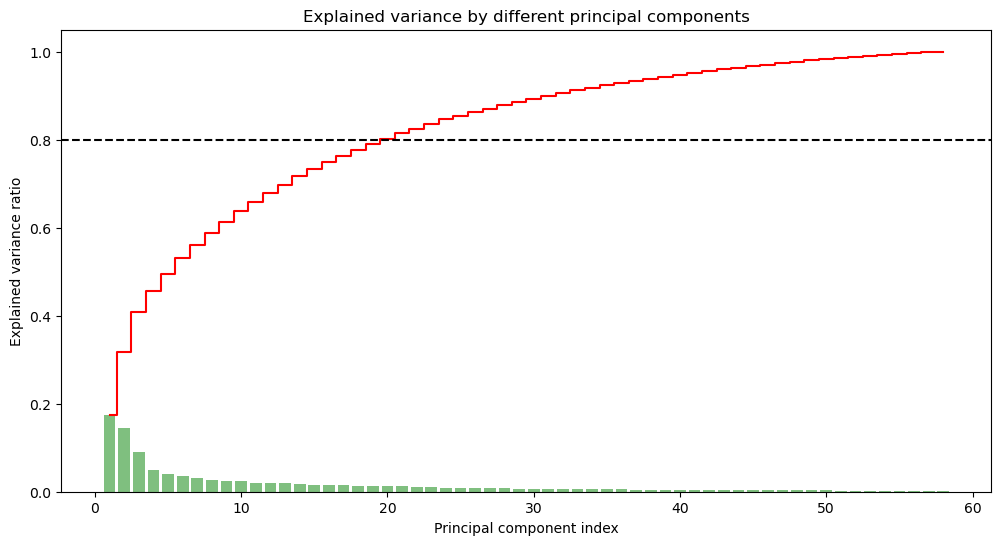

In [50]:
# Investigate the variance accounted for by each principal component.
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, color="g")
plt.step(range(1, len(explained_variance) + 1), cumulative_variance, where="mid", color="r")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.axhline(y=0.8, color="k", linestyle="--")
plt.title("Explained variance by different principal components")
plt.show()

In [51]:
# Number of components needed to explain 80% of the variance
n_components = np.argmax(cumulative_variance >= .8) + 1
print(f"Number of components needed to explain 80% of variance: {n_components}")

Number of components needed to explain 80% of variance: 20


In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_final = PCA(n_components=n_components)
azdias_pca_final = pca_final.fit_transform(azdias_scaled)
print(f"Final PCA data shape: {azdias_pca_final.shape}")

Final PCA data shape: (798067, 20)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After analyzing the cumulative explained variance graph, we observed that 20 principal components account for over 80% of the total variance in the dataset. We decided to retain 20 principal components since this threshold preserves most of the meaningful information while reducing dimensionality.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Principal_Component = w_1 * X_1 + w_2 * X_2 + ... + x_n * X_n

def interpret_pca_component(pca, feature_names, component_idx=0, n_top_features=10):
    """
    Function to interpret the princpal components.

    INPUT:
        pca - Fitted PCA model
        feature_names - List of feature names
        component_idx - Index of the component to interpret (default: 0 for first PC)
        n_top_features - Number of top positive and negative features to display


    OUTPUT:
        Prints the top positive and negative features for the specified component
    """
    # Get component weights
    component = pca.components_[component_idx]
    weights = pd.DataFrame({
        "Feature": feature_names,
        "Weight": component
    })

    # Get top positive and negative weights
    top_positive = weights[weights["Weight"] > 0].sort_values("Weight", ascending=False).head(n_top_features)
    top_negative = weights[weights["Weight"] < 0].sort_values("Weight", ascending=True).head(n_top_features)

    # Print results
    print(f"Principal Component: {component_idx + 1}\n")

    print("Top positive features:")
    for _, row in top_positive.iterrows():
        print(f"  {row['Feature']}: {row['Weight']:.4f}")

    print("\nTop negative features:")
    for _, row in top_negative.iterrows():
        print(f"  {row['Feature']}: {row['Weight']:.4f}")

# Interpret 1st principal component

interpret_pca_component(pca=pca_final, feature_names=azdias_scaled.columns, component_idx=0)

Principal Component: 1

Top positive features:
  FINANZ_MINIMALIST: 0.2331
  PLZ8_ANTG1: 0.2201
  MOBI_REGIO: 0.2199
  KBA05_GBZ: 0.2106
  KBA05_ANTG1: 0.2086
  KONSUMNAEHE: 0.1668
  INNENSTADT: 0.1664
  PLZ8_GBZ: 0.1609
  ALTERSKATEGORIE_GROB: 0.1564
  FINANZ_VORSORGER: 0.1466

Top negative features:
  PLZ8_ANTG3: -0.2217
  PLZ8_ANTG4: -0.2132
  ORTSGR_KLS9: -0.1983
  EWDICHTE: -0.1965
  HH_EINKOMMEN_SCORE: -0.1907
  FINANZ_SPARER: -0.1807
  PLZ8_ANTG2: -0.1520
  KBA05_ANTG4: -0.1492
  SEMIO_PFLICHT: -0.1480
  FINANZ_HAUSBAUER: -0.1474


In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Interpret 2n principal component

interpret_pca_component(pca_final, azdias_scaled.columns, component_idx=1)

Principal Component: 2

Top positive features:
  ALTERSKATEGORIE_GROB: 0.2451
  FINANZ_VORSORGER: 0.2203
  SEMIO_ERL: 0.2085
  SEMIO_LUST: 0.1741
  RETOURTYP_BK_S: 0.1659
  FINANZ_HAUSBAUER: 0.1378
  PLZ8_ANTG3: 0.1308
  EWDICHTE: 0.1297
  ORTSGR_KLS9: 0.1283
  PLZ8_ANTG4: 0.1276

Top negative features:
  SEMIO_REL: -0.2345
  DECADE: -0.2305
  SEMIO_TRADV: -0.2203
  FINANZ_UNAUFFAELLIGER: -0.2190
  FINANZ_SPARER: -0.2185
  SEMIO_PFLICHT: -0.2149
  FINANZ_ANLEGER: -0.2070
  SEMIO_KULT: -0.1958
  ONLINE_AFFINITAET: -0.1725
  SEMIO_RAT: -0.1669


In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Interpret 3rd principal component

interpret_pca_component(pca_final, azdias_scaled.columns, component_idx=2)

Principal Component: 3

Top positive features:
  SEMIO_VERT: 0.3746
  SEMIO_SOZ: 0.2932
  SEMIO_FAM: 0.2849
  SEMIO_KULT: 0.2700
  FINANZ_MINIMALIST: 0.1620
  RETOURTYP_BK_S: 0.1033
  SEMIO_REL: 0.0988
  FINANZ_VORSORGER: 0.0928
  W_KEIT_KIND_HH: 0.0837
  SEMIO_MAT: 0.0780

Top negative features:
  SEMIO_KAEM: -0.3682
  SEMIO_DOM: -0.3460
  SEMIO_KRIT: -0.3095
  SEMIO_RAT: -0.2147
  SEMIO_ERL: -0.2103
  FINANZ_ANLEGER: -0.1890
  DECADE: -0.1032
  FINANZ_SPARER: -0.0985
  FINANZ_UNAUFFAELLIGER: -0.0903
  SEMIO_PFLICHT: -0.0618


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The **1st principal component** is related to features:

1. Top positive values
    - FINANZ_MINIMALIST (Financial typology: low financial interest)
    - PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
    - MOBI_REGIO (Movement patterns)

2. Top negative values
    - PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
    - PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)
    - ORTSGR_KLS9 (Size of community)
  
The 1st principal component reveals a contrast between residential environments; distinguishing between rural or suburban areas with single-family homes (positive correlation) against urban areas with multi-family buildings and larger communities (negative correlation).

The **2nd principal component** is related to features:

1. Top positive values
    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    - FINANZ_VORSORGER (Financial typology: be prepared)
    - SEMIO_ERL (Personality typology: event-oriented)

2. Top negative values
    - SEMIO_REL (Personality typology: religious)
    - DECADE (generation)
    - SEMIO_TRADV (Personality typology: traditional-minded)

The 2nd principal component reveals a contrast between lifestype orientations. It appears to contrast older, financially prepared, and event-oriented individuals (positive correlation) against more religious, traditional individuals from different generations (negative correlation).

The **3rd principal component** is related to features:

1. Top positive values
    - SEMIO_VERT (Personality typology: dreamful)
    - SEMIO_SOZ (Personality typology: socially-minded)
    - SEMIO_FAM (Personality typology: family-minded)
  
2. Top negative values
    - SEMIO_KAEM (Personality typology: combative attitude)
    - SEMIO_DOM (Personality typology: dominant-minded)
    - SEMIO_KRIT (Personality typology: critical-minded)
  
The 3rd principal component reveals a contrast between personality types; distinguishing between dreamful, socially-minded, and family-oriented individuals (positive correlation) against more combative, dominant, and critically-minded invidiuals (negative correlation).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average within-cluster distances.
from sklearn.cluster import KMeans

# Range of cluster counts to try
cluster_range = range(2, 21)
scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(azdias_pca_final)

    # Score (negative mean squared distance to nearest centroid)
    # Larger values (closer to zero) are better
    score = kmeans.score(azdias_pca_final)
    scores.append(score)

    print(f"Done clustering with {n_clusters} clusters. Score: {score:.2f}")

Done clustering with 2 clusters. Score: -31605670.01
Done clustering with 3 clusters. Score: -27875109.64
Done clustering with 4 clusters. Score: -26095927.27
Done clustering with 5 clusters. Score: -24994157.17
Done clustering with 6 clusters. Score: -23941273.80
Done clustering with 7 clusters. Score: -22743901.09
Done clustering with 8 clusters. Score: -22281006.04
Done clustering with 9 clusters. Score: -21908803.40
Done clustering with 10 clusters. Score: -21108358.92
Done clustering with 11 clusters. Score: -20716053.19
Done clustering with 12 clusters. Score: -20264682.20
Done clustering with 13 clusters. Score: -19943430.58
Done clustering with 14 clusters. Score: -19668052.64
Done clustering with 15 clusters. Score: -19395323.42
Done clustering with 16 clusters. Score: -19215005.11
Done clustering with 17 clusters. Score: -18481527.83
Done clustering with 18 clusters. Score: -18252012.20
Done clustering with 19 clusters. Score: -18032267.32
Done clustering with 20 clusters. Sc

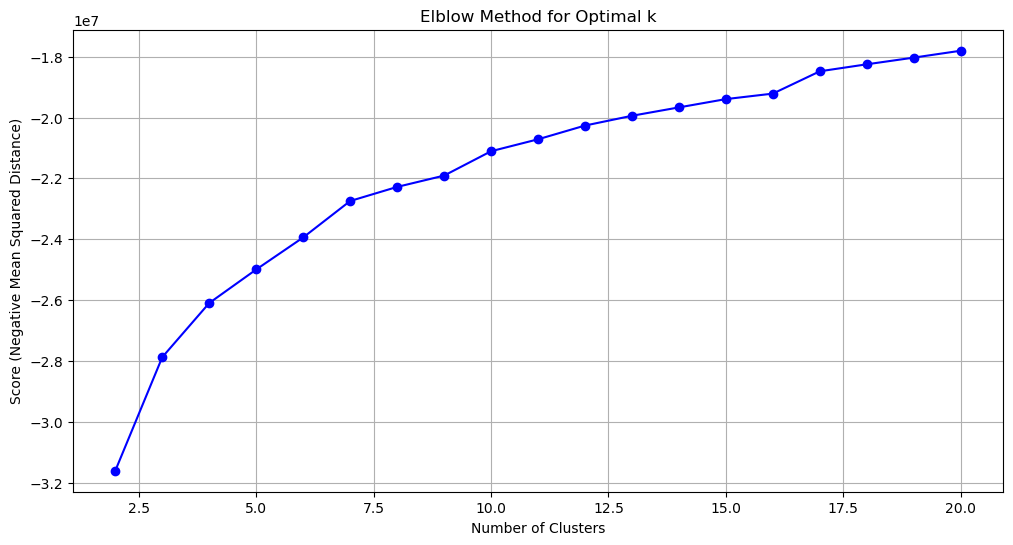

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
import matplotlib.pyplot as plt

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Score (Negative Mean Squared Distance)")
plt.title("Elblow Method for Optimal k")
plt.grid(True)
plt.show()

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 8 # Based on the elbow curve

# Re-fit K-means
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_final.fit(azdias_pca_final)

# Clusters for the general population
azdias_clusters = kmeans_final.predict(azdias_pca_final)

# Number of data points in each cluster
population_cluster_counts = pd.Series(azdias_clusters).value_counts().sort_index()
print("Number of data points in each cluster:")
print(population_cluster_counts)

Number of data points in each cluster:
0    105972
1     84561
2    108686
3    103293
4    105118
5    102043
6     84348
7    104046
dtype: int64


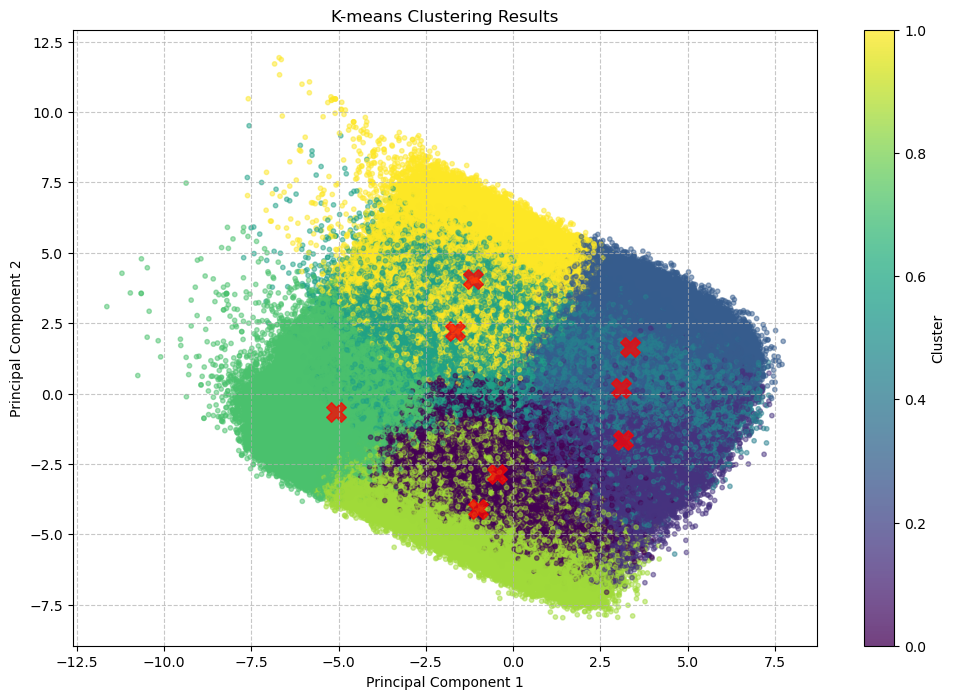

In [59]:
# Let's visualize clusters using the first 2 principal components

# This scatter plot represents how the data points from each principal component are organized in the reduced-dimensional space
# - Each points represents an observation projected onto the 2 principal components
# - Each color indicates a different cluster from the K-means algorithm
# - Each cluster centroid is marked with a red X

plt.figure(figsize=(12, 8))

# Scatter plot colored by cluster
plt.scatter(azdias_pca_final[:, 0], azdias_pca_final[:, 1], 
            c=azdias_clusters, cmap='viridis', 
            alpha=0.5, s=10)

# Plot cluster centers
centers = kmeans_final.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], 
            c='red', s=200, alpha=0.75, marker='X')

plt.title('K-means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# How to interpret a point in this plot:
# For example: (PC1, PC2) = (-6, -2.5)
# PC1 = -6:   Since it's a negative value, earlier analysis of PC1 suggests this it's more likely to be in an urban environment
#             with multi-family buildings, higher household density, and located in a larger community.
# PC2 = -2.5: Since it's a negative value, earlier analysis of PC2 suggests this it's more likely to have religious and
#             traditional characteristics, possibly from an older generation (indicated by the DECADE variable)

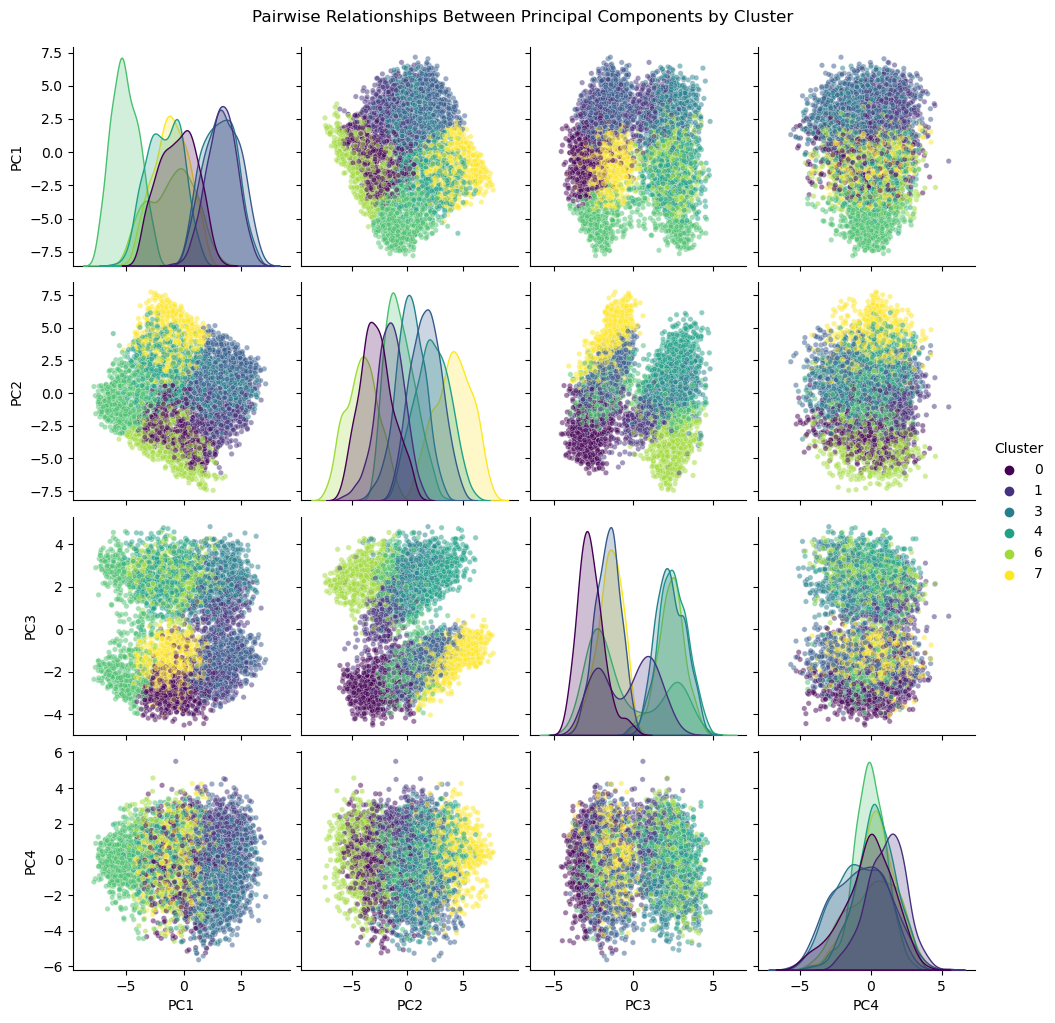

In [60]:
# Let's create a pairplot showing clusters across 4 principal components 
import seaborn as sns

# Number of principal components to plot
n_components_to_plot = 4

pca_df = pd.DataFrame(
    data=azdias_pca_final[:, :n_components_to_plot],
    columns=[f'PC{i+1}' for i in range(n_components_to_plot)]
)
pca_df['Cluster'] = azdias_clusters

# Sample if needed
if len(pca_df) > 5000:
    pca_df = pca_df.sample(5000, random_state=42)

# Pairplot
sns.pairplot(pca_df, hue='Cluster', palette='viridis', diag_kind='kde', 
             plot_kws={'alpha': 0.5, 's': 15}, height=2.5)
plt.suptitle('Pairwise Relationships Between Principal Components by Cluster', y=1.02)
plt.show()

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Based on the analysis of the German population demographics data, we identified 8 clusters as the optimal segmentation using the eblow method on the K-means clustering socres.

When visualized in the principal component space, these 8 clusters exhibit a clear separation across dimensions. The clusters are well-balanced in size and capture distinct demographic segments while maintaining model simplicity.

This 8-cluster solution provides a strong framework for targeted marketing strategies without introducing unnecessary complexity.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
print("Customer data shape:", customers.shape)

Customer data shape: (191652, 85)


In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply the same cleaning function to the customer data
customers_clean = clean_data(customers, feat_info)
print("Cleaned customer data shape:", customers_clean.shape)
print("Missing values in cleaned customer data:", customers_clean.isnull().sum().sum())

# Let's make sure customers_clean has exactly the same columns as azdias_subset
# Drop any columns in customers_clean not in azdias_subset
extra_columns = [col for col in customers_clean.columns if col not in azdias_subset.columns]
if extra_columns:
    print(f"Dropping {len(extra_columns)} extra columns from customer data: {extra_columns}")
    customers_clean = customers_clean.drop(columns=extra_columns)

# Add any columns from azdias_subset not in customers_clean
missing_columns = [col for col in azdias_subset.columns if col not in customers_clean.columns]
if missing_columns:
    print(f"Adding {len(missing_columns)} missing columns to customer data: {missing_columns}")
    for col in missing_columns:
        customers_clean[col] = 0

# Make sure columns are in the same order and verify
# Order is important because some algorithms rely on column index instead of name
customers_clean = customers_clean[azdias_subset.columns]
print("Column check - Same columns in same order:", all(customers_clean.columns == azdias_subset.columns))

Missing values before preprocessing: 2252274
Missing values after preprocessing: 2704706
Columns to drop: ['KK_KUNDENTYP', 'KKK', 'REGIOTYP']
Cleaned customer data shape: (141725, 67)
Missing values in cleaned customer data: 90141
Dropping 11 extra columns from customer data: ['AGER_TYP', 'ANREDE_KZ', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'OST_WEST_KZ', 'KBA05_BAUMAX', 'LIFE_STAGE']
Adding 2 missing columns to customer data: ['KKK', 'REGIOTYP']
Column check - Same columns in same order: True


In [63]:
# Apply the same imputation (using already fitted imputer)
customers_imputed = pd.DataFrame(imputer.transform(customers_clean), columns=customers_clean.columns)
customers_imputed.columns = customers_clean.columns
customers_imputed.index = customers_clean.index

# Apply the same scaling (using already fitted scaler)
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_imputed.columns)

# Apply the same PCA transformation (using already fitted PCA)
customers_pca = pca_final.transform(customers_scaled)
print("Customer PCA data shape:", customers_pca.shape)

# Predict the clusters for the customer data (using already fitted K-means)
customer_clusters = kmeans_final.predict(customers_pca)

# Count the number of customers in each cluster
customer_cluster_counts = pd.Series(customer_clusters).value_counts().sort_index()
print("Number of customers in each cluster:")
print(customer_cluster_counts)

Customer PCA data shape: (141725, 20)
Number of customers in each cluster:
0     3017
1     5570
2    28422
3    72796
4    14247
5     1466
6     3305
7    12902
dtype: int64


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_proportions = pd.Series(azdias_clusters).value_counts(normalize=True).sort_index()
customer_proportions = customer_cluster_counts / customer_cluster_counts.sum()

# DataFrame to compare proportions
comparison_df = pd.DataFrame({
    "Cluster": population_proportions.index,
    "General Population (%)": population_proportions * 100,
    "Customer Data (%)": customer_proportions * 100,
    "Difference (Δ%)": (customer_proportions - population_proportions) * 100,
    "Ratio (Customer/Population)": customer_proportions / population_proportions
})

# Sort by ratio to identify over and under-represented clusters
comparison_df = comparison_df.set_index("Cluster").sort_values("Ratio (Customer/Population)", ascending=False)

In [65]:
comparison_df

,General Population (%),Customer Data (%),Difference (Δ%),Ratio (Customer/Population)
Cluster,,,,
3,12.942898,51.364262,38.421363,3.968529
2,13.618656,20.054331,6.435674,1.472563
4,13.171576,10.052567,-3.119009,0.763202
7,13.037251,9.103546,-3.933706,0.698272
1,10.595727,3.930146,-6.665581,0.370918
6,10.569037,2.331981,-8.237056,0.220643
0,13.278584,2.128771,-11.149814,0.160316
5,12.786270,1.034398,-11.751872,0.080899


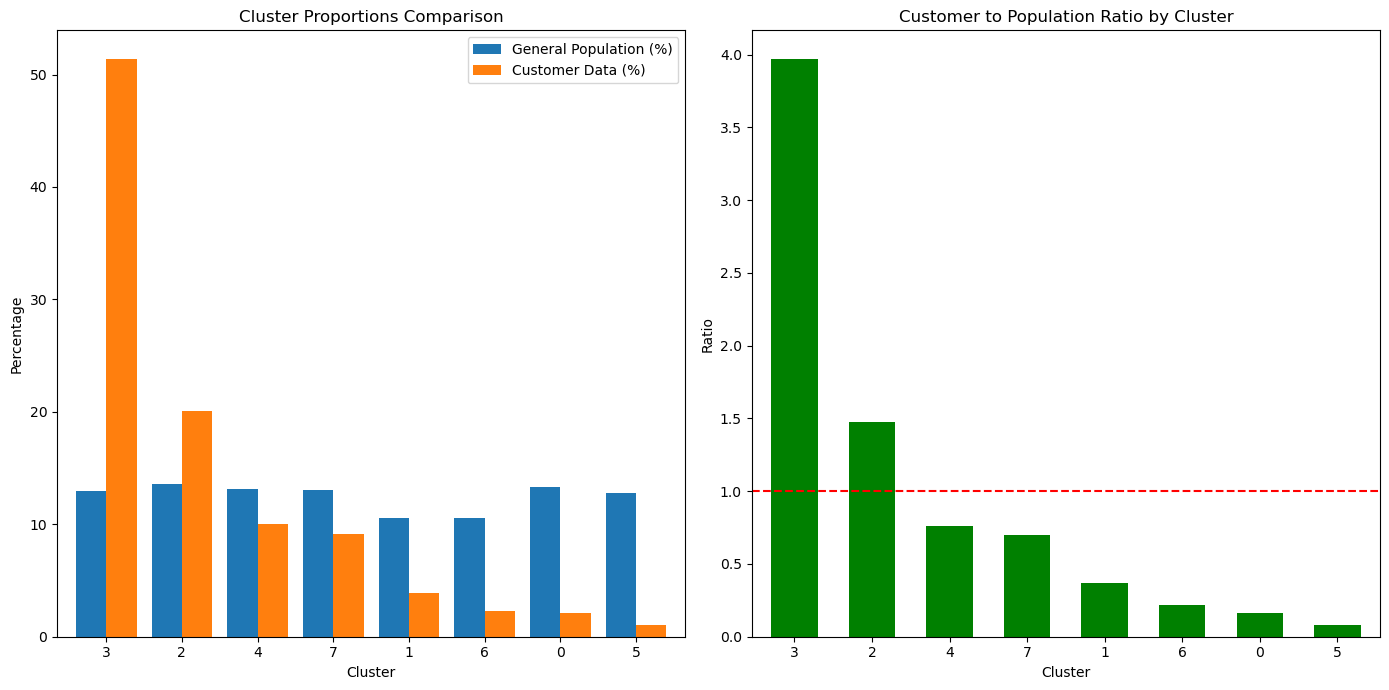

In [66]:
# Visualize the cluster comparison
plt.figure(figsize=(14, 7))

# Plot cluster proportions
ax1 = plt.subplot(1, 2, 1)
comparison_df[["General Population (%)", "Customer Data (%)"]].plot(kind="bar", ax=ax1, width=0.8)
plt.title("Cluster Proportions Comparison")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.legend()

# Plot ratio
ax2 = plt.subplot(1, 2, 2)
comparison_df["Ratio (Customer/Population)"].plot(kind="bar", ax=ax2, color="green", width=0.6)
plt.title("Customer to Population Ratio by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.axhline(y=1, color="red", linestyle="--") # Reference line at ratio=1
plt.tight_layout()
plt.show()

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# When we say "Cluster X is over-represented in the customer data", we mean the proportion of customers falling
# into Cluster X is higher than the proportion of prople in the general population falling into that same cluster.
# Example: if Cluster 3 contains 10% of the general population but 25% of our customer base, this 2.5x
# over-representation means that people who have characteristics of Cluster 3 are more likely to become
# our customers than people from other clusters.

overrepresented_clusters = comparison_df.head(3).index.tolist()
underrepresented_clusters = comparison_df.tail(3).index.tolist()

print("Most over-represented clusters:", overrepresented_clusters)
print("Most under-represented clusters:", underrepresented_clusters)

# Analyze cluster centers to understand what types of people they represent
cluster_centers_pca = kmeans_final.cluster_centers_

# Map back to original feature space
cluster_centers_scaled = pca_final.inverse_transform(cluster_centers_pca)
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# DataFrame of cluster centers in original feature space
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=customers_imputed.columns)

# Analyze clusters
def analyze_cluster(cluster, cluster_centers_df, comparison_df, n_features=10):
    """
    Analyze distinctive features of a cluster.

    INPUT:
        cluster: Cluster ID to analyze
        cluster_centers_df: DataFrame of cluster centers
        comparison_df: DataFrame with cluster comparisons
        n_features: Number of top features to display
    """
    # Get customer/population ratio
    ratio = comparison_df.loc[cluster, "Ratio (Customer/Population)"]
    print(f"\nCluster {cluster} (Customer/Population ratio: {ratio:.2f}):")

    # Compare cluster center to overall average
    center_values = cluster_centers_df.loc[cluster]
    overall_avg = cluster_centers_df.mean() # Avg of each feature across all clusters

    # Calculate absolute deviations from overall average
    # Deviations between a cluster center and the overall avg measure how different
    # that cluster is from the "typical" data point across the entire dataset
    deviations = abs(center_values - overall_avg)
    top_features = deviations.sort_values(ascending=False).head(n_features)

    # Display most distinctive features and their values
    for feature in top_features.index:
        value = center_values[feature]
        avg = overall_avg[feature]
        print(f"  {feature}: {value:.2f} (Overall avg: {avg:.2f})")

print("\nCharacteristics of over-represented clusters:")
for cluster in overrepresented_clusters:
    analyze_cluster(cluster, cluster_centers_df, comparison_df, n_features=10)

print("\nCharacteristics of under-represented clusters:")
for cluster in underrepresented_clusters:
    analyze_cluster(cluster, cluster_centers_df, comparison_df, n_features=10)

# Notes about why large deviations define meaningful cluster characteristics:
# Large deviations are more meaningful because they are less likely to occur by chance, meaning that feature genuinely distinguishes the cluster.
# Features with the largest deviations are often the ones used by the clustering algorithm used to separate the group from others.

Most over-represented clusters: [3, 2, 4]
Most under-represented clusters: [6, 0, 5]

Characteristics of over-represented clusters:

Cluster 3 (Customer/Population ratio: 3.97):
  KBA13_ANZAHL_PKW: 744.31 (Overall avg: 631.15)
  ANZ_HAUSHALTE_AKTIV: 2.22 (Overall avg: 8.13)
  SEMIO_VERT: 6.10 (Overall avg: 4.34)
  FINANZ_MINIMALIST: 4.68 (Overall avg: 3.07)
  SEMIO_KAEM: 2.66 (Overall avg: 4.22)
  FINANZ_ANLEGER: 1.50 (Overall avg: 2.88)
  FINANZ_SPARER: 1.38 (Overall avg: 2.75)
  SEMIO_DOM: 3.15 (Overall avg: 4.49)
  SEMIO_RAT: 2.61 (Overall avg: 3.89)
  HH_EINKOMMEN_SCORE: 3.21 (Overall avg: 4.39)

Cluster 2 (Customer/Population ratio: 1.47):
  KBA13_ANZAHL_PKW: 731.08 (Overall avg: 631.15)
  ANZ_HAUSHALTE_AKTIV: 2.22 (Overall avg: 8.13)
  SEMIO_KULT: 1.95 (Overall avg: 4.21)
  SEMIO_FAM: 2.02 (Overall avg: 4.18)
  SEMIO_REL: 1.99 (Overall avg: 4.05)
  SEMIO_ERL: 6.43 (Overall avg: 4.55)
  SEMIO_SOZ: 2.66 (Overall avg: 4.20)
  SEMIO_MAT: 2.37 (Overall avg: 3.91)
  SEMIO_PFLICHT: 2.79

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

After analyzing and clustering the results, we identified distinct customer segments that are either significantly over-represented or under-represented in the mail-order company's customer base compared to the general population.

The most over-represented clusters are Clusters 3 and 2, representing population segmentes that are approx. 4x and 1.5x more likely to be customers than we would expect based on their presence in the general population.

**Popular Customer Segments:**

- **Cluster 3** (Customer/Population ratio: 3.97) represents the company's core customers. These individuals are characterized by:
    - Higher car density in the PLZ8 region (KBA13_ANZAHL_PKW: 744 vs avg 631)
    - Living in buildings with fewer households (ANZ_HAUSHALTE_AKTIV: 2.22 vs avg 8.13)
    - Exhibit a personality with low dreamfulness (SEMIO_VERT: 6.10 vs avg 4.34, where 6 indicates "very low affinity")
    - Ver low interest in financial matters (FINANZ_MINIMALIST: 4.68 vs avg 3.07, where 4 indicates "low" financial interest)
    - Very high combative attitude (SEMIO_KAEM: 2.66 vs avg 4.22, where 2 indicates "very high affinity")
    - Very high investment orientation (FINANZ_ANLEGER: 1.50 vs avg 2.88, where 1 indicates "very high" investment orientation)
    - Very high savings orientation (FINANZ_SPARER: 1.38 vs avg 2.75, where 1 indicates "very high" savings orientation)
 
This suggests that the company appeals to individuals who manage their money through investments and savings, despite showing lower general interest in financial matters. They tend to live in less densely populated buildings in regions with many cars, and display combative personalities.

- **Cluster 2** (Customer/Population ratio: 1.47) represents another important customer segment characterized by:
    - Higher car density in the PLZ8 region (KBA13_ANZAHL_PKW: 731 vs avg 631)
    - Living in buildings with fewer households (ANZ_HAUSHALTE_AKTIV: 2.22 vs avg 8.13)
    - Very high cultural-minded personality (SEMIO_KULT: 1.95 vs avg 4.21, where 1 indicates "highest affinity")
    - Very high family-minded personality (SEMIO_FAM: 2.02 vs avg 4.18)
    - Very high religious values (SEMIO_REL: 1.99 vs avg 4.05)
    - Very low event-oriented personality (SEMIO_ERL: 6.43 vs avg 4.55, where 6 indicates "very low affinity")
 
This suggests that the company also appeals to more traditional and value-oriented individuals who prioritize family or religious values, and similarly live in less densely populated buildings in well-connected regions.

In general, we can say that popular customer segmentes are characterized by a tendency toward either financial prudence or traditional values, and reside in regions with low population density and good transportation infrastructure. These customers likely base their purchase decisions on quality, reliability, and practicality.

**Unpopular Customer Segments:**

- **Cluster 5** (Customer/Population ratio: 0.08) is particularly notable as these individuals are 12.5x less likely to be customers. They are characterized by:
    - Lower car density in the PLZ8 region (KBA13_ANZAHL_PKW: 473 vs avg 631)
    - Living in buildings with many households (ANZ_HAUSHALTE_AKTIV: 18.69 vs avg 8.13)
    - Living in large cities (ORTSGR_KLS9: 7.49 vs avg 5.23, indicating communities of 100,001-300,000 inhabitants)
    - Very low sense of duty (SEMIO_PFLICHT: 5.96 vs avg 4.22, where 5 indicates "low affinity")
    - Very high financial interest (FINANZ_MINIMALIST: 1.32 vs avg 3.07, where 1 indicates "very high" financial interest)
    - Very high savings orientation (FINANZ_SPARER: 4.37 vs avg 2.75, where 4 indicates "low" savings orientation)
 
This suggests that urban dwellers living in densely populated buildings in larger cities with less access to cars are significantly less likely to engage with the company. These individuals have a high interest in financial matters but don't prioritize saving. These customers might prefer immediate gratification or have different spending priorities than what the company's offerings provide.

- **Cluster 0** (Customer/Population ratio: 0.16) represents individuals characterized by:
    - Higher car density in the PLZ8 region (KBA13_ANZAHL_PKW: 728 vs avg 631)
    - Living in buildings with fewer households(ANZ_HAUSHALTE_AKTIV: 4.17 vs avg 8.13)
    - Very low rationality (SEMIO_RAT: 6.07 vs avg 3.89, where 6 indicates "very low affinity")
    - Low investment orientation (FINANZ_ANLEGER: 4.35 vs avg 2.88, where 4 indicates "low" investment orientation)
    - Low savings orientation (FINANZ_SPARER: 4.03 vs avg 2.75, where 4 indicates "low" savings orientation)
 
This suggests that despite sharing similar residential characteristics with popular segments, these individuals' purchasing decisions are less driven by rational consideration and financial planning. Their low engagement with the company might indicate that the company's value proposition appeals more to rational, financially-minded customers rather than impulse buyers.

In general, we can say that unpopular customer segments are characterized by either urban living with high-density housing, or by spending patterns that prioritize immediate consumption over saving and investment. Both groups show little alignment with the company's apparent focus on practical, considered purchasing decisions.

These findings suggest that the company should focus its marketing efforts on financially cautious individuals with traditional family values who live in less densely populated areas with good transportation infrastructure. However, if the company considers appealing to urban customers, it should consider developing new strategies to emphasize convenience and immediate value rather than long-term benefits.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.